In [1]:
from utils.loading import load_models
from diffusers import DDPMScheduler
import torch
import torch.mps

root = 'iCD-SD15_4steps_2'
ldm_stable, reverse_cons_model, forward_cons_model = load_models(
    model_id="runwayml/stable-diffusion-v1-5",
    device='cuda' if torch.cuda.is_available() else 'cpu',
    forward_checkpoint=f'{root}/iCD-SD15-forward_19_249_499_699.safetensors',
    reverse_checkpoint=f'{root}/iCD-SD15-reverse_249_499_699_999.safetensors',
    r=64,
    w_embed_dim=512,
    teacher_checkpoint=f'{root}/sd15_cfg_distill.pt',
)

tokenizer = ldm_stable.tokenizer
noise_scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="scheduler", )

/opt/homebrew/anaconda3/envs/icd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/anaconda3/envs/icd/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/homebrew/anaconda3/envs/icd/lib/python3.10/site-p

Forward CD is initialized with guidance embedding, dim 512


Some weights of UNet2DConditionModel were not initialized from the model checkpoint at runwayml/stable-diffusion-v1-5 and are newly initialized: ['time_embedding.cond_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedded model is loading from iCD-SD15_4steps_2/sd15_cfg_distill.pt
Reverse CD is loading from iCD-SD15_4steps_2/iCD-SD15-reverse_249_499_699_999.safetensors
Forward CD is loading from iCD-SD15_4steps_2/iCD-SD15-forward_19_249_499_699.safetensors


### Edit

In [2]:
from utils import p2p, generation

NUM_REVERSE_CONS_STEPS = 4
REVERSE_TIMESTEPS = [249, 499, 699, 999]
NUM_FORWARD_CONS_STEPS = 4
FORWARD_TIMESTEPS = [19, 259, 519, 779]
NUM_DDIM_STEPS = 50

solver = generation.Generator(
    model=ldm_stable,
    noise_scheduler=noise_scheduler,
    n_steps=NUM_DDIM_STEPS,
    forward_cons_model=forward_cons_model,
    forward_timesteps=FORWARD_TIMESTEPS,
    reverse_cons_model=reverse_cons_model,
    reverse_timesteps=REVERSE_TIMESTEPS,
    num_endpoints=NUM_REVERSE_CONS_STEPS,
    num_forward_endpoints=NUM_FORWARD_CONS_STEPS,
    max_forward_timestep_index=49,
    start_timestep=19)

p2p.NUM_DDIM_STEPS = NUM_DDIM_STEPS
p2p.tokenizer = tokenizer
p2p.device = 'cuda' if torch.cuda.is_available() else 'cpu'

Endpoints reverse CTM: tensor([999, 699, 499, 249]), tensor([699, 499, 249,   0])
Endpoints forward CTM: tensor([ 19, 259, 519, 779]), tensor([259, 519, 779, 999])


In [3]:
from utils import inversion

image_path = f"assets/bird.jpg"
prompt = ["a photo of a bird standing on a branch"]

(image_gt, image_rec), ddim_latent, uncond_embeddings = inversion.invert(
    # Playing params
    image_path=image_path,
    prompt=prompt,

    # Fixed params
    is_cons_inversion=True,
    w_embed_dim=512,
    inv_guidance_scale=0.0,
    stop_step=50,
    solver=solver,
    seed=10500)

4it [00:18,  4.68s/it]


/Users/edgar/Downloads/invertible-cd/utils/generation.py:542: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size, model.unet.in_channels, height // 8, width // 8).to(model.device)
4it [00:53, 13.41s/it]


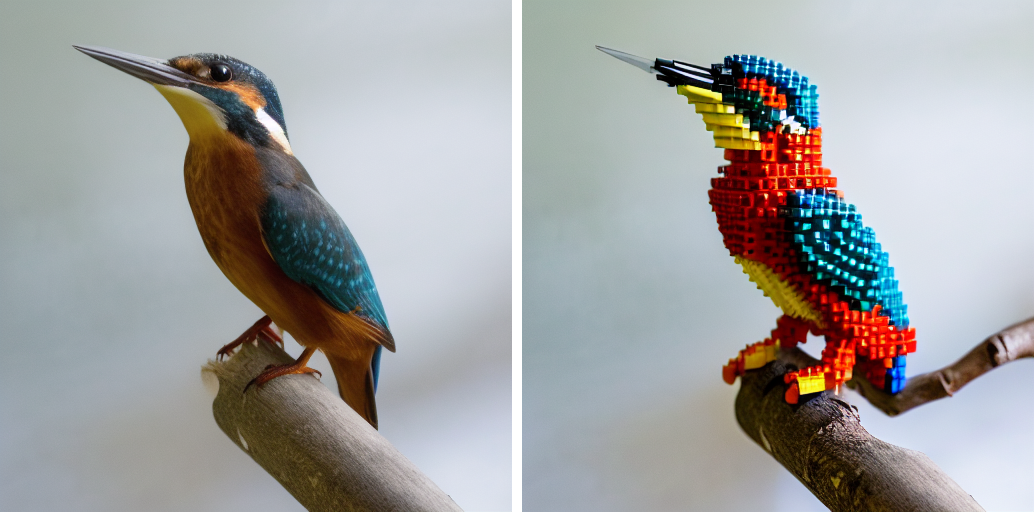

In [4]:
p2p.NUM_DDIM_STEPS = 4
p2p.tokenizer = tokenizer
p2p.device = 'cuda' if torch.cuda.is_available() else 'cpu'

prompts = ["a photo of a bird standing on a branch",
           "a photo of a lego bird standing on a branch"
           ]

# Playing params
cross_replace_steps = {'default_': 0.2, }
self_replace_steps = 0.2
blend_word = ((('bird',), ('lego',)))
eq_params = {"words": ("lego",), "values": (3.,)}

controller = p2p.make_controller(prompts,
                                 False, # (is_replacement) True if only one word is changed
                                 cross_replace_steps,
                                 self_replace_steps,
                                 blend_word,
                                 eq_params)

tau = 0.8
image, _ = generation.runner(
    # Playing params
    guidance_scale=19.0,
    tau1=tau,  # Dynamic guidance if tau < 1.0
    tau2=tau,

    # Fixed params
    model=reverse_cons_model,
    is_cons_forward=True,
    w_embed_dim=512,
    solver=solver,
    prompt=prompts,
    controller=controller,
    num_inference_steps=50,
    generator=None,
    latent=ddim_latent,
    uncond_embeddings=uncond_embeddings,
    return_type='image')

generation.to_pil_images(image).save('test_editing_iCD-SD1.5.jpg')
generation.view_images(image)

### Generation

In [5]:
# prompt = ['a cute owl with a graduation cap']
# controller = p2p.AttentionStore()

# generator = torch.Generator().manual_seed(150)
# tau = 1.
# image, _ = generation.runner(
#     # Playing params
#     guidance_scale=19.0,
#     tau1=tau,  # Dynamic guidance if tau < 1.0
#     tau2=tau,

#     # Fixed params
#     is_cons_forward=True,
#     model=reverse_cons_model,
#     w_embed_dim=512,
#     solver=solver,
#     prompt=prompt,
#     controller=controller,
#     generator=generator,
#     latent=None,
#     return_type='image')

# # The left image is inversion, the right - editing.
# generation.to_pil_images(image).save('test_generation_iCD-SD1.5.jpg')
# generation.view_images(image)

### Evaluation

In [13]:
import json
import os
import csv
from utils.loading import load_benchmark

In [ ]:
MAPPING_FILE = f"{os.getcwd()}/running/benchmarks/PIE_Bench/mapping_file.json"
IMAGE_ROOT_PATH = f"{os.getcwd()}/running/benchmarks/PIE_Bench/anotation_images"
METRICS = []

with open(MAPPING_FILE, 'r') as f:
    data = json.load(f)